In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import models, datasets, transforms

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../data/SkinCancer/train')
data_dir_test = pathlib.Path('../data/SkinCancer/test')
data_dir_val = pathlib.Path('../data/SkinCancer/val')

In [6]:
# DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_train,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #normalize
        ])
    ),
    batch_size=128,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_test,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #normalize
        ])
    ),
    batch_size=128,
    shuffle=False
)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_val,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #normalize
        ])
    ),
    batch_size=128,
    shuffle=False 
)

In [7]:
sam2_checkpoint = "../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [8]:
# display the first image in the training set
first_image, _ = next(iter(train_loader))
first_image = first_image[0]#.to(device)
first_image.shape

torch.Size([3, 224, 224])

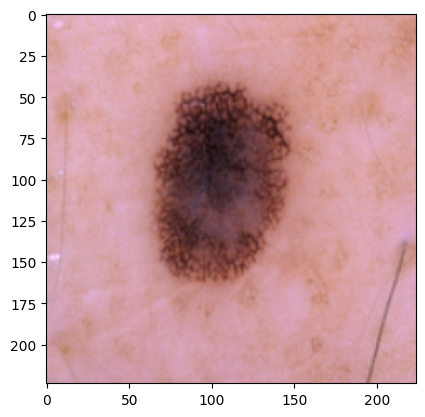

In [9]:
plt.imshow(first_image.permute(1, 2, 0))

In [16]:
predictor.set_image(np.array(first_image.permute(1, 2, 0)))

In [17]:
input_point = np.array([[112, 112]])
input_label = np.array([1])

In [18]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

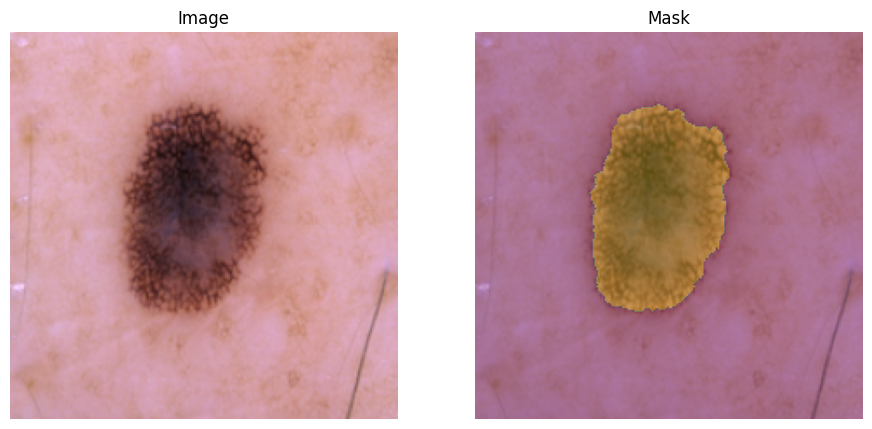

In [34]:
# show image with masks on top of the image

#color_mask = np.array([30/255, 144/255, 255/255, 0.6])
best_mask = np.clip(masks[0], 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(11, 6))

ax[0].imshow(first_image.permute(1, 2, 0))
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(first_image.permute(1, 2, 0))
ax[1].imshow(best_mask, alpha=0.3)
ax[1].set_title("Mask")
ax[1].axis("off")


plt.show()

In [35]:
#auto generated masks
automasks, autoscores, autologits = predictor.predict(
    point_coords=None,
    point_labels=None,
    multimask_output=True,
)

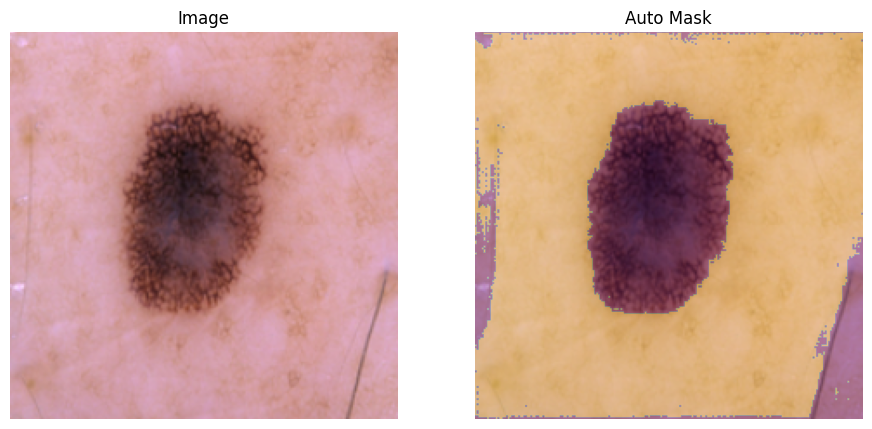

In [40]:
# show auto generated masks on top of the image

#color_mask = np.array([30/255, 144/255, 255/255, 0.6])
best_mask = np.clip(automasks[0], 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(11, 6))

ax[0].imshow(first_image.permute(1, 2, 0))
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(first_image.permute(1, 2, 0))
ax[1].imshow(best_mask, alpha=0.3)
ax[1].set_title("Auto Mask")
ax[1].axis("off")

plt.show()

In [ ]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [ ]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()